# url: https://qiita.com/pigooosuke/items/4e03fb09a190f1878407

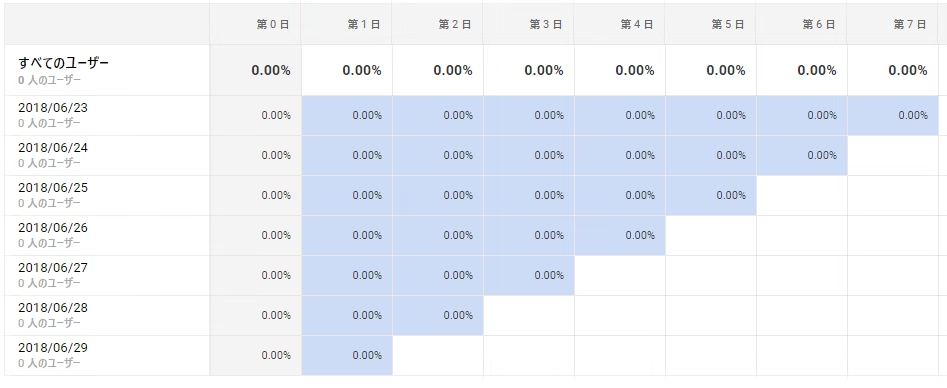

# pythonでコホート分析

コホート図と呼ばれ、Webサービス・アプリサービスに対するユーザーの継続率を確認することができます。

マーケティングの分野で主に使われ、
- 短期的なマーケティング施策の効果測定
- 特定のユーザー層のエンゲージメント測定

などミクロな視点でサービス状況を確認できます。

基本的に、GoogleAnalyticsやfirebaseアナリティクスなどマーケティングサービスの標準機能として付属していますが、ユーザーのイベントログを多面的にチェックしようと思うと応用が効かず。

python(pandas)で集計しようと思いましたが、あまり良さそうなリソースがなく、（あることはあるが、集計ミスが起きうる書き方をしている・・・）１から手で書く上での基本的な手順をまとめてみました。





## データ準備

手頃なオープンデータセットがあればいいのですが、Webサービスのいい感じのユーザーログは公開されておらず、（かなり探したけれど見つからなかったです）まずデータセットを作るところから始めます。

今回作るのはかなり簡易的なデータです。
- customer_id
- event_date (特定のログが記録された日付)

これを週次で観察してみます。

In [1]:
import random
import pandas as pd
from datetime import datetime, timedelta

def random_date(start, end):
    """startとendの差をday変換してランダムで選択して、startに加算"""
    delta = end - start
    int_delta = (delta.days)
    random_day = random.randrange(int_delta)

    return (start + timedelta(days=random_day)).strftime("%Y-%m-%d")

def random_id(n_size):
    return random.choice(range(n_size))

def create_dataset(d_length, n_size, start_day, end_day):
    """ datasetをつくる
    customer_id: user
    event_date: action(ログイン、特定のログなど、なにかしらの行動が発生した日)
    weekofyear: event_dateがその年の何週目にあたるか
    """
    d_list = []
    for _ in range(d_length):
        d_list.append([random_id(n_size),random_date(start_day, end_day)])
    # dataframeに変換
    df = pd.DataFrame(d_list, columns=["customer_id","event_date"])
    # event_dateがその年の何週目にあたるのかを算出
    df["weekofyear"] = pd.to_datetime(df["event_date"]).dt.weekofyear

    return df

d1 = datetime.strptime('2018-01-01', '%Y-%m-%d')
d2 = datetime.strptime('2018-06-01', '%Y-%m-%d')
df = create_dataset(20000, n_size=1000, start_day = d1, end_day = d2)
df.head()

# 2018年1月から6月までで、1000ユーザー分のログを2万件生成します。
# 併せて、そのイベント日が1年のうち何週目に当たるかを3列目に入れています。

<ipython-input-1-d0c04a499f6e>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["weekofyear"] = pd.to_datetime(df["event_date"]).dt.weekofyear


,customer_id,event_date,weekofyear
0,450,2018-03-25,12
1,683,2018-05-13,19
2,432,2018-03-30,13
3,661,2018-04-08,14
4,155,2018-04-21,16


## 集計作業
今回特定のイベントを行ったユーザーの継続率を確認するために、ユーザー単位でそれぞれ一番古いイベントの日付を特定します。



In [2]:
# merge
# df.mergeメソッドのsuffixesパラメータは、結合するデータフレームの列名が衝突した場合に、それらの列名に接尾辞を付けるために使用されます。
# suffixesは接尾辞を指定するためのタプルで、その構造は (left_suffix, right_suffix) です。これはサブテーブルのカラム名の変更。
# prefixes=("left_", "right_")も存在する。これはメインテーブルのカラム名の変更。

df = df.merge(df.groupby("customer_id")["event_date"].min().reset_index(), on="customer_id", suffixes=("","_init") , how="left")

# 初回のイベント日についてもweekodyearを計算
df["weekofyear_init"] = pd.to_datetime(df["event_date_init"]).dt.weekofyear
df.head()

<ipython-input-2-340530370ac3>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["weekofyear_init"] = pd.to_datetime(df["event_date_init"]).dt.weekofyear


,customer_id,event_date,weekofyear,event_date_init,weekofyear_init
0,450,2018-03-25,12,2018-01-08,2
1,683,2018-05-13,19,2018-01-02,1
2,432,2018-03-30,13,2018-01-07,1
3,661,2018-04-08,14,2018-01-02,1
4,155,2018-04-21,16,2018-01-02,1


In [3]:
# 今回、特定期間から行動を始めたユーザーが各週でどう行動しているのかを確認しています。
# そのため、マトリックスを作成し、それぞれに何ユーザー存在するかをカウントすればOKです。

gp = df.groupby(["weekofyear_init","weekofyear"], as_index=False)["customer_id"].nunique().rename(columns = {"customer_id": "customer_count"})
gp.head()

# 以下の２行目で言うと、1週に行動したユーザーのうち、２週目に行動したユーザー数が366人いたということがわかります。
# 図示していくためには、さらに工夫が必要で、そのweekofyearはweekofyear_initから数えて何週目に当たるのかを計算してみます。

,weekofyear_init,weekofyear,customer_count
0,1,1,599
1,1,2,360
2,1,3,365
3,1,4,360
4,1,5,352


In [4]:
# weekofyear_init(初回イベント発生日)から見て、それぞれのイベントが何周目後に発生したものかを集計
gp["cohort_group"] = gp["weekofyear"] - gp["weekofyear_init"] + 1
gp.head()

,weekofyear_init,weekofyear,customer_count,cohort_group
0,1,1,599,1
1,1,2,360,2
2,1,3,365,3
3,1,4,360,4
4,1,5,352,5


In [5]:
# これをピボットテーブルに落としてみます。
# ピボットテーブルのデフォルトの集計関数は mean です。したがって、このコードでは "customer_count" 列の平均が計算されます。
user_retention = gp.pivot_table(values="customer_count", columns="cohort_group", index="weekofyear_init")
user_retention.head(20)

# user_retention と repeat は似ていますが、通常、これらの用語は異なる文脈で使用されることがあります。

# User Retention (ユーザーリテンション):
# ユーザーリテンションは、特定の期間内にサービスやプロダクトを使用し続けるユーザーの割合を示します。
# 例えば、1週間後にもサービスを利用しているユーザーの割合や、1か月後にも利用しているユーザーの割合などを計算することがあります。
# 通常、時間に基づいてユーザーの継続的な利用を追跡する指標です。

# Repeat (リピート):
# リピートは、ユーザーが同じ行動や購買を繰り返すことを指します。これは特定の行動の反復を意味します。
# 例えば、特定の製品を複数回購入することや、特定の機能を繰り返し利用することが考えられます。
# リピートは単一の行動の反復を強調する傾向があります。

# 要するに、ユーザーリテンションは時間の経過に伴うユーザーの継続的な利用を追跡する指標であり、
# リピートは特定の行動や購買が何度も繰り返されることを指します。同じユーザーが同じ行動を何度も繰り返す場合、その行動はリピートしていると言えます。



# 以下の表がまさにGAとかでよく目にするやつです。
# ここの数字はユーザー数になっているので、１週目を元として比率に変換してみます。

cohort_group,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
weekofyear_init,,,,,,,,,,,,,,,,,,,,,
1,599.0,360.0,365.0,360.0,352.0,373.0,369.0,355.0,360.0,369.0,...,362.0,373.0,342.0,369.0,375.0,357.0,349.0,383.0,344.0,241.0
2,250.0,142.0,139.0,148.0,163.0,147.0,156.0,150.0,161.0,139.0,...,147.0,147.0,157.0,149.0,151.0,143.0,147.0,151.0,126.0,NaN
3,87.0,49.0,49.0,52.0,50.0,55.0,44.0,51.0,35.0,52.0,...,49.0,55.0,48.0,53.0,58.0,60.0,58.0,33.0,NaN,NaN
4,44.0,25.0,28.0,31.0,27.0,29.0,19.0,25.0,28.0,28.0,...,25.0,31.0,25.0,27.0,28.0,29.0,14.0,NaN,NaN,NaN
5,13.0,5.0,8.0,7.0,6.0,8.0,9.0,7.0,5.0,7.0,...,8.0,11.0,7.0,4.0,7.0,1.0,NaN,NaN,NaN,NaN
6,7.0,5.0,7.0,2.0,5.0,5.0,5.0,4.0,5.0,2.0,...,3.0,7.0,5.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# それぞれのイベント初日のユーザー数を取得し、各イベント期間にどれだけユーザーが残っていたのかを計算
user_retention = user_retention.apply(lambda x : x / x.iloc[0], axis=1) #axis=1: 行方向
user_retention.head()

cohort_group,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
weekofyear_init,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.601002,0.609349,0.601002,0.587646,0.622705,0.616027,0.592654,0.601002,0.616027,...,0.604341,0.622705,0.570952,0.616027,0.626043,0.595993,0.582638,0.639399,0.57429,0.402337
2,1.0,0.568000,0.556000,0.592000,0.652000,0.588000,0.624000,0.600000,0.644000,0.556000,...,0.588000,0.588000,0.628000,0.596000,0.604000,0.572000,0.588000,0.604000,0.50400,NaN
3,1.0,0.563218,0.563218,0.597701,0.574713,0.632184,0.505747,0.586207,0.402299,0.597701,...,0.563218,0.632184,0.551724,0.609195,0.666667,0.689655,0.666667,0.379310,NaN,NaN
4,1.0,0.568182,0.636364,0.704545,0.613636,0.659091,0.431818,0.568182,0.636364,0.636364,...,0.568182,0.704545,0.568182,0.613636,0.636364,0.659091,0.318182,NaN,NaN,NaN
5,1.0,0.384615,0.615385,0.538462,0.461538,0.615385,0.692308,0.538462,0.384615,0.538462,...,0.615385,0.846154,0.538462,0.307692,0.538462,0.076923,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Cohort Analysis: User Retention'}, xlabel='cohort_group', ylabel='weekofyear_init'>

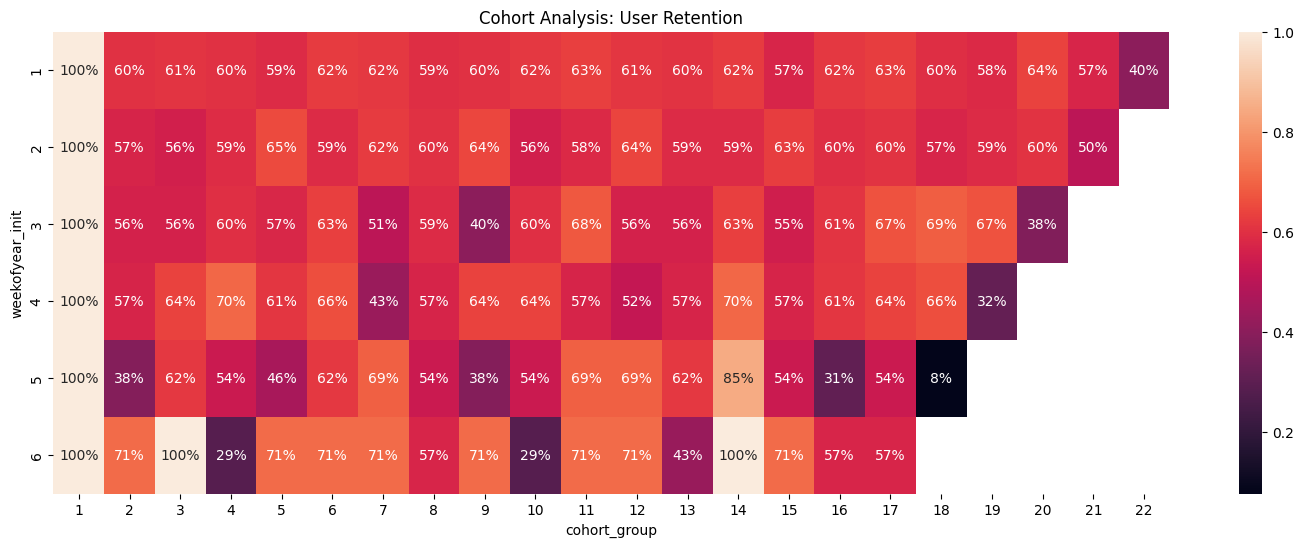

In [7]:
# 最後にプロットしてみると

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 6))
plt.title('Cohort Analysis: User Retention')
sns.heatmap(user_retention, mask = user_retention.isnull(), annot=True, fmt='.0%')

# 完成です。
# 今回は非常に簡易的な集計を行いましたが、
# 特定のユーザー層を元に、特定の行動を行っているのかを独自で集計したい場合はこのような形で集計しましょう。

# 追加

In [8]:
tmp = []

for i in range(len(user_retention.index)):
    row_mean = user_retention.iloc[i, 1:].mean()
    tmp.append(row_mean)

tmp_df = pd.DataFrame(tmp, columns=['mean_rate'], index = user_retention.index)
tmp_df['yoy'] = round(tmp_df['mean_rate'] / tmp_df['mean_rate'].shift(1),2) #year-over-year(前年比): yoy
display(tmp_df)

,mean_rate,yoy
weekofyear_init,,
1,0.596391,NaN
2,0.593800,1.00
3,0.580157,0.98
4,0.589646,1.02
5,0.533937,0.91
6,0.651786,1.22


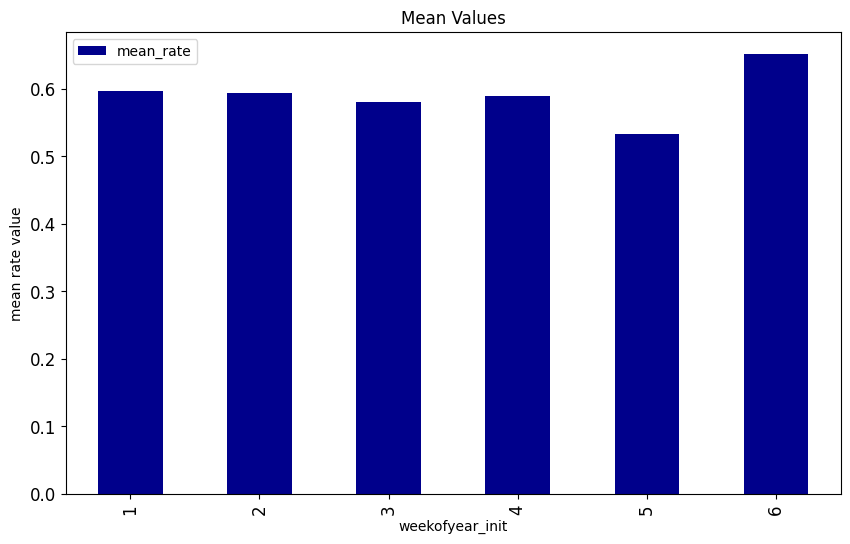

In [9]:
# tmp_dfを棒グラフで表示（カスタマイズ）
tmp_df['mean_rate'].plot(kind = "bar", figsize = (10, 6), title = 'Mean Values', legend = True, color = 'darkblue', fontsize = 12)
plt.xlabel('weekofyear_init')
plt.ylabel('mean rate value')
# plt.grid(True)
plt.show()

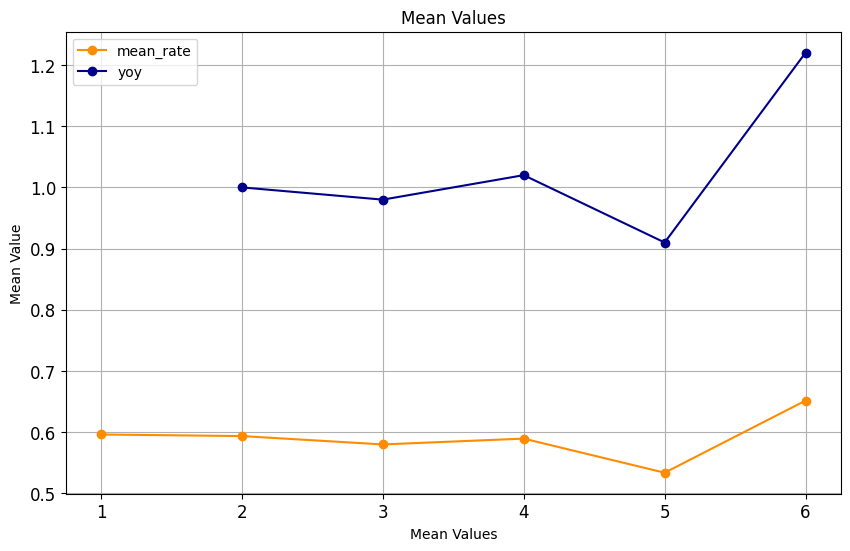

In [10]:
# tmp_dfを折れ線グラフで表示（カスタマイズ）
tmp_df['mean_rate'].plot(kind="line", figsize = (10, 6), title = 'Mean Values', legend = True, color = 'darkorange', marker = 'o', fontsize = 12)
tmp_df['yoy'].plot(kind="line", figsize = (10, 6), title = 'Mean Values', legend = True, color = 'darkblue', marker = 'o', fontsize = 12)
plt.xlabel('Mean Values')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()